# OPTICAL CHARACTER RECOGNITION (OCR)

OCR is a term used to represent computer vision algorithms which read texts from images. In this notebook we explore OCR capabilities of RESNET18.

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#### explore the data set

In [2]:
os.listdir('/home/azza/Documents/archive/CNN letter Dataset')

['H',
 'U',
 'L',
 'F',
 'V',
 'W',
 '0',
 'C',
 'D',
 'Z',
 'P',
 'A',
 'G',
 'B',
 '1',
 '8',
 'J',
 '9',
 'K',
 '7',
 'R',
 '4',
 '3',
 'M',
 'E',
 '2',
 'Y',
 '5',
 'S',
 '6',
 'X',
 'Q',
 'I',
 'T',
 'N']

In [3]:
data_transforms=transforms.Compose([transforms.Resize((240,240)),transforms.ToTensor()])

In [4]:
data=torchvision.datasets.ImageFolder(root='/home/azza/Documents/archive/CNN letter Dataset',transform=data_transforms)

In [5]:
train_loader=torch.utils.data.DataLoader(dataset=data,batch_size=32,shuffle=False)

In [6]:
def get_mean_and_std(loader):
    mean=0.
    std=0.
    total_images_count=0
    for images,_ in loader:
        image_count_in_a_batch=images.size(0)
        images=images.view(image_count_in_a_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std +=images.std(2).sum(0)
        total_images_count +=image_count_in_a_batch
    mean/=total_images_count
    std/=total_images_count
    
    return mean, std

In [7]:
get_mean_and_std(train_loader)

(tensor([0.4918, 0.4918, 0.4918]), tensor([0.1951, 0.1951, 0.1951]))

## data prepation

In [8]:
train_data='/home/azza/Documents/archive/CNN letter Dataset'
test_data='/home/azza/Documents/archive/CNN letter Dataset'

In [9]:
mean=[0.1307]
std=[0.301]

#transforms.RandomHorizontalFlip(),

train_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
])

test_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
])

In [10]:
train_dataset=torchvision.datasets.ImageFolder(root=train_data,transform=train_transforms)
test_dataset=torchvision.datasets.ImageFolder(root=test_data,transform=test_transforms)

In [11]:
def show_transformed_images(dataset):
    loader=torch.utils.data.DataLoader(dataset,batch_size=6,shuffle=True)
    batch=next(iter(loader))
    images,labels=batch
    
    grid=torchvision.utils.make_grid(images,nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels:',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([13,  0, 14, 17,  3,  2])


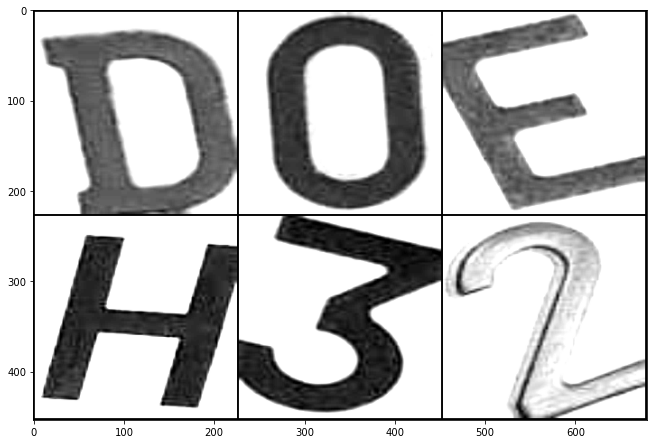

In [12]:
show_transformed_images(train_dataset)

In [13]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False)


### traing of resnet18

In [14]:
def set_device():
    if torch.cuda.is_available():
        dev='cuda:0'
    else:
        dev='cpu'
    return torch.device(dev)

In [15]:
def train_nn(model, train_loader,test_loader, criterion,optimizer,n_epochs):
    device=set_device()
    for epoch in range(n_epochs):
        print("Epoch number %d"%(epoch+1))
        model.train()
        running_loss=0.0
        running_correct=0.0
        total=0
        
        for data in train_loader:
            images,labels=data
            images=images.to(device)
            labels=labels.to(device)
            total+=labels.size(0)
            
            optimizer.zero_grad()
            
            outputs=model(images)
            
            _,predicted=torch.max(outputs.data,1)
            
            loss=criterion(outputs,labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss +=loss.item()
            
            running_correct +=(labels==predicted).sum().item()
            
        epoch_loss=running_loss/len(train_loader)
        
        epoch_accuracy=100.00*running_correct/total
        
        print('   - Training dataset. Got %d out of %d images correctly (Epoch accuracy: %.3f%%). Epoch loss: %.3f'
             % (running_correct,total,epoch_accuracy,epoch_loss))
        evaluate_model_on_test_set(model,test_loader)
        
    print('Finished')

    return model

In [16]:
def evaluate_model_on_test_set(model,test_loader):
    model.eval()
    predicted_correctly_on_epoch=0
    total=0
    device=set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images,labels=data
            images=images.to(device)
            labels=labels.to(device)
            total+=labels.size(0)
            
            outputs=model(images)
            
            _,predicted=torch.max(outputs.data,1)
            
            predicted_correctly_on_epoch+=(predicted==labels).sum().item()
            
        epoch_accuracy=100.00*predicted_correctly_on_epoch/total
        
        print('    - Testing dataset. Got %d out of %d images correctly (Epoch accuracy: %.3f%%)'
             % (predicted_correctly_on_epoch,total,epoch_accuracy))
    

In [17]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim


resnet18_model=models.resnet18(pretrained=False)
num_ftrs= resnet18_model.fc.in_features
number_of_classes=35
resnet18_model.fc=nn.Linear(num_ftrs,number_of_classes)
device=set_device()
resnet_18_OCR_model=resnet18_model.to(device)
loss_fn=nn.CrossEntropyLoss()

optimizer=optim.SGD(resnet18_model.parameters(),lr=0.01,momentum=0.9,weight_decay=0.003)


/home/azza/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/azza/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# ##############################################################################

In [18]:
train_nn(resnet_18_OCR_model,train_loader,test_loader,loss_fn,optimizer,30)

Epoch number 1
   - Training dataset. Got 31468 out of 35500 images correctly (Epoch accuracy: 88.642%). Epoch loss: 0.437
    - Testing dataset. Got 35042 out of 35500 images correctly (Epoch accuracy: 98.710%)
Epoch number 2
   - Training dataset. Got 35424 out of 35500 images correctly (Epoch accuracy: 99.786%). Epoch loss: 0.031
    - Testing dataset. Got 35450 out of 35500 images correctly (Epoch accuracy: 99.859%)
Epoch number 3
   - Training dataset. Got 35421 out of 35500 images correctly (Epoch accuracy: 99.777%). Epoch loss: 0.033
    - Testing dataset. Got 35265 out of 35500 images correctly (Epoch accuracy: 99.338%)
Epoch number 4
   - Training dataset. Got 35400 out of 35500 images correctly (Epoch accuracy: 99.718%). Epoch loss: 0.037
    - Testing dataset. Got 35458 out of 35500 images correctly (Epoch accuracy: 99.882%)
Epoch number 5
   - Training dataset. Got 35454 out of 35500 images correctly (Epoch accuracy: 99.870%). Epoch loss: 0.026
    - Testing dataset. Got 35

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### saving the trained model

In [19]:
import os
import torch

# # Assuming `model` is your trained PyTorch model
# save_dir = '/home/azza/Documents/'
# os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save the model
save_path = '/home/azza/Documents/OCR_resnet18_model.pth'
torch.save(resnet_18_OCR_model.state_dict(), save_path)
print("Model saved at", save_path)

Model saved at /home/azza/Documents/OCR_resnet18_model.pth


#### loading the saved model to be tested

In [94]:
import torch

# Load the model
model = torch.load('/home/azza/Documents/OCR_resnet18_model.pth')

In [104]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

image_path = '/home/azza/Documents/archive/CNN letter Dataset/R/aug5326_5.jpg' ## R ##
input_image = Image.open(image_path)
input_image = input_image.convert("RGB")  # Convert to RGB format
# preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
])
input_tensor = preprocess(input_image)
input_batch = torch.unsqueeze(input_tensor, 0)

In [117]:
import torch
from torchvision.models import resnet18
import torch.nn as nn

# Create an instance of the ResNet18 model
OCRM = resnet18(pretrained=False)

# Modify the last fully connected layer
num_classes = 35  # Change this to your desired number of classes
OCRM.fc = nn.Linear(OCRM.fc.in_features, num_classes)

# Load the saved model state dictionary
OCRM.load_state_dict(model)

# Set the model in evaluation mode
OCRM.eval()

# Continue with the prediction code...
output = OCRM(input_batch)

In [106]:
output

tensor([[-0.0534, -0.5256, -0.1623,  0.1570, -1.0398, -0.0454,  0.1911, -0.1534,
          0.7133, -1.0744, -1.4350,  1.1050, -1.5265,  0.6257, -0.4662,  0.5205,
          0.3651,  0.2815, -0.4755, -1.4159,  1.3380, -1.5996, -0.8665,  0.9880,
          1.5006, -0.1292,  9.5918, -1.0325,  0.4217, -1.8282, -1.5701,  0.3813,
          0.6990, -2.1658, -1.3139]], grad_fn=<AddmmBackward0>)

In [107]:
# Process the output
_, predicted_idx = torch.max(output, 1)
characters=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N',
            'P','Q','R','S','T','U','V','W','X','Y','Z']
predicted_label = characters[predicted_idx.item()]
print("Predicted label:", predicted_label)

Predicted label: R


## Applying the model on a number plate:

In [293]:
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
from PIL import Image
import os
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt

### a function to read a single character

In [294]:
def read_character(image):
    input_image=Image.fromarray(image)
    input_image = input_image.convert("RGB")  # Convert to RGB format
    # preprocess = transforms.Compose([
    #     transforms.Resize(256),
    #     transforms.CenterCrop(224),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # ])
    preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    input_tensor = preprocess(input_image)
    input_batch = torch.unsqueeze(input_tensor, 0)

    # Load the saved model
    OCRM = resnet18(pretrained=False)
    num_classes = 35  # Change this to your desired number of classes
    OCRM.fc = nn.Linear(OCRM.fc.in_features, num_classes)
    model = torch.load('/home/azza/Documents/OCR_resnet18_model.pth')
    state_dict = model
    OCRM.load_state_dict(state_dict)
    OCRM.eval()
    # Continue with the prediction code...
    output = OCRM(input_batch)
    # Process the output
    _, predicted_idx = torch.max(output, 1)
    characters=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N',
                'P','Q','R','S','T','U','V','W','X','Y','Z']
    predicted_label = characters[predicted_idx.item()]
    #print("Predicted label:", predicted_label)
    return predicted_label

### an integrated function to read the whole number plate using resnet18 and connected componet analysis (CCA)

In [302]:

# Load the image
image = cv2.imread("/home/azza/Documents/DATADATA/number_plate_image.jpg")

def read_numberplate(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 10)

    # Apply morphological operations to enhance the characters
    kernel = np.ones((3, 3), np.uint8)
    morphology = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(morphology, connectivity=8)

    # Set the minimum and maximum area for character extraction
    min_area = 100
    max_area = 10000

    # Iterate through the connected components and extract the character regions
    characters = []
    for label in range(1, num_labels):
        # Get the area of the connected component
        area = stats[label, cv2.CC_STAT_AREA]

        # Filter connected components based on area
        if area > min_area and area < max_area:
            # Get the bounding box of the connected component
            x, y, width, height = stats[label, cv2.CC_STAT_LEFT], stats[label, cv2.CC_STAT_TOP], \
                                  stats[label, cv2.CC_STAT_WIDTH], stats[label, cv2.CC_STAT_HEIGHT]

            # Extract the character region from the original image
            character = image[y:y+height, x:x+width]

            # Append the character region to the list
            characters.append(character)

    # # Process the extracted character regions
    # for character in characters:
    #     # Apply further processing or recognition on each character
    #     # ...

    # Display the segmented characters
    i=0
    numberplate=''
    if read_character(characters[0])=='R':
        numberplate='R'
        for character in characters[1:]:
            if character.shape[0]>100:
                c=read_character(character)
                if c=='D' and (i==3 or 4 or 5):
                    c='0'
                numberplate+=c
                print("Predicted label:",c)
                plt.imshow(character)
                plt.title('Character {}'.format(i+1))
                plt.show()
                i+=1
    else:
        for character in characters:
            if character.shape[0]>100:
                c=read_character(character)
                if c=='T' and i==0:
                        c='I'
                if c=='D' and (i==3 or 4 or 5):
                        c='0'
                numberplate+=c
                print("Predicted label:",c)
                plt.imshow(character)
                plt.title('Character {}'.format(i+1))
                plt.show()
                i+=1
    return numberplate

### time to read

Predicted label: I


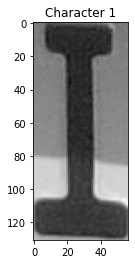

Predicted label: T


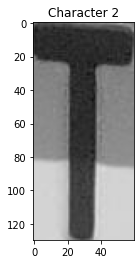

Predicted label: 3


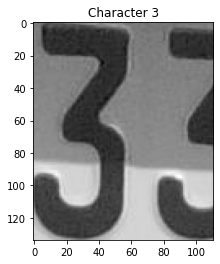

Predicted label: 3


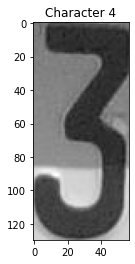

Predicted label: 0


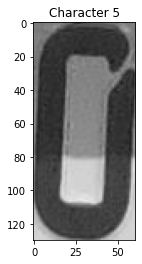

Predicted label: R


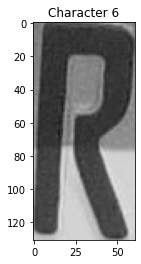

Predicted label: G


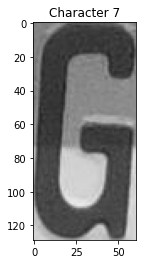

In [303]:
NP=read_numberplate(image)

IT330RG


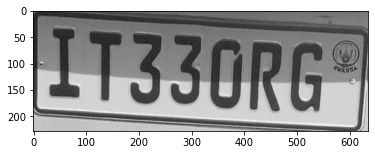

In [305]:
plt.imshow(image)
print(NP)

### NOTE: 
Because of the number plate shapes and format differencies of the datasets trained on and the actual number plates to be tested the OCR model was not found to be so accurate on the actual number plates in Rwanda. However, the performance of resnet18 is promising.